# 0. Импортируем необходимые библиотеки

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv
/kaggle/input/GiveMeSomeCredit/cs-test.csv


# 1. Загрузка и исследование данных

## 1.1. Загрузим необходимые для работы данные

In [2]:
train = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-training.csv")
test = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-test.csv")

train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 1.2. Опишем, что означает каждый признак в датасете

> **Целевая переменная**:

1. **SeriousDlqin2yrs**:

   - **Что это значит:** Клиент допустит серьёзную просрочку платежа (не менее чем на 90 дней) в течение следующих двух лет.
   - **Значения:** 1 (да) или 0 (нет)

> **Признаки**:

1. **RevolvingUtilizationOfUnsecuredLines**:
   - **Что это значит:** Это процент использования доступного кредитного лимита по кредитным картам и личным кредитным линиям, не связанным с недвижимостью. Например, если у вас есть кредитная карта с лимитом 100 000 рублей, и вы на данный момент потратили 30 000 рублей, то ваш показатель будет 30%.
   - **Зачем это нужно:** Этот показатель показывает, насколько активно человек использует свои кредитные ресурсы. Высокое значение может указывать на то, что человек активно пользуется кредитами и, возможно, находится на грани своих финансовых возможностей.
   - **Значения:** percentage
   
2. **Age**:
   - **Что это значит:** Возраст заемщика в годах.
   - **Зачем это нужно:** Возраст может быть связан с жизненным этапом и финансовой стабильностью. Например, молодые заемщики могут иметь меньше финансового опыта, а пожилые могут уже иметь стабильный доход или наоборот быть на пенсии.
   - **Значения:** integer

3. **NumberOfTime30-59DaysPastDueNotWorse**:
   - **Что это значит:** Количество раз, когда заемщик просрочил платежи на 30-59 дней, но не более, за последние два года.
   - **Зачем это нужно:** Просрочки платежей указывают на финансовые трудности или недисциплинированность заемщика. Чем больше таких случаев, тем выше риск для банка.
   - **Значения:** integer

4. **DebtRatio**:
   - **Что это значит:** Соотношение всех ежемесячных долговых платежей (включая алименты и расходы на жизнь) к ежемесячному доходу заемщика. Например, если вы зарабатываете 100 000 рублей в месяц, а ваши обязательные платежи составляют 50 000 рублей, то ваш DebtRatio будет 50%.
   - **Зачем это нужно:** Этот показатель показывает, сколько из своих доходов человек тратит на погашение долгов. Высокий DebtRatio может говорить о том, что заемщику будет сложно справляться с новыми финансовыми обязательствами.
   - **Значения:** percentage

5. **MonthlyIncome**:
   - **Что это значит:** Ежемесячный доход заемщика.
   - **Зачем это нужно:** Доход напрямую влияет на способность заемщика погашать кредит. Чем выше доход, тем меньше риск для банка.
   - **Значения:** real

6. **NumberOfOpenCreditLinesAndLoans**:
   - **Что это значит:** Количество открытых кредитов (например, автокредитов или ипотек) и кредитных линий (например, кредитных карт).
   - **Зачем это нужно:** Этот показатель показывает, насколько много у заемщика активных финансовых обязательств. Много открытых кредитов может свидетельствовать о перегруженности долгами.
   - **Значения:** integer

7. **NumberOfTimes90DaysLate**:
   - **Что это значит:** Количество раз, когда заемщик просрочил платежи на 90 дней или больше.
   - **Зачем это нужно:** Просрочка на 90 дней и более — это серьезный сигнал для банка о том, что заемщик может быть ненадежен в плане возврата долга.
   - **Значения:** integer

8. **NumberRealEstateLoansOrLines**:
   - **Что это значит:** Количество ипотек и других кредитов, связанных с недвижимостью, включая кредитные линии под залог жилья.
   - **Зачем это нужно:** Это показатель того, сколько недвижимости заемщик уже приобрел в кредит. Множество таких кредитов может увеличить нагрузку на бюджет заемщика.
   - **Значения:** integer

9. **NumberOfTime60-89DaysPastDueNotWorse**:
   - **Что это значит:** Количество раз, когда заемщик просрочил платежи на 60-89 дней, но не более, за последние два года.
   - **Зачем это нужно:** Это еще один показатель финансовой дисциплины заемщика. Просрочки в этом диапазоне могут указывать на временные, но существенные трудности с выплатами.
   - **Значения:** integer

10. **NumberOfDependents**:
    - **Что это значит:** Количество людей, находящихся на иждивении заемщика (например, супруг, дети), кроме самого заемщика.
    - **Зачем это нужно:** Чем больше у человека иждивенцев, тем больше его финансовая нагрузка, что может повлиять на его способность вовремя погашать кредит.
    - **Значения:** integer

## 1.3. Изучим данные

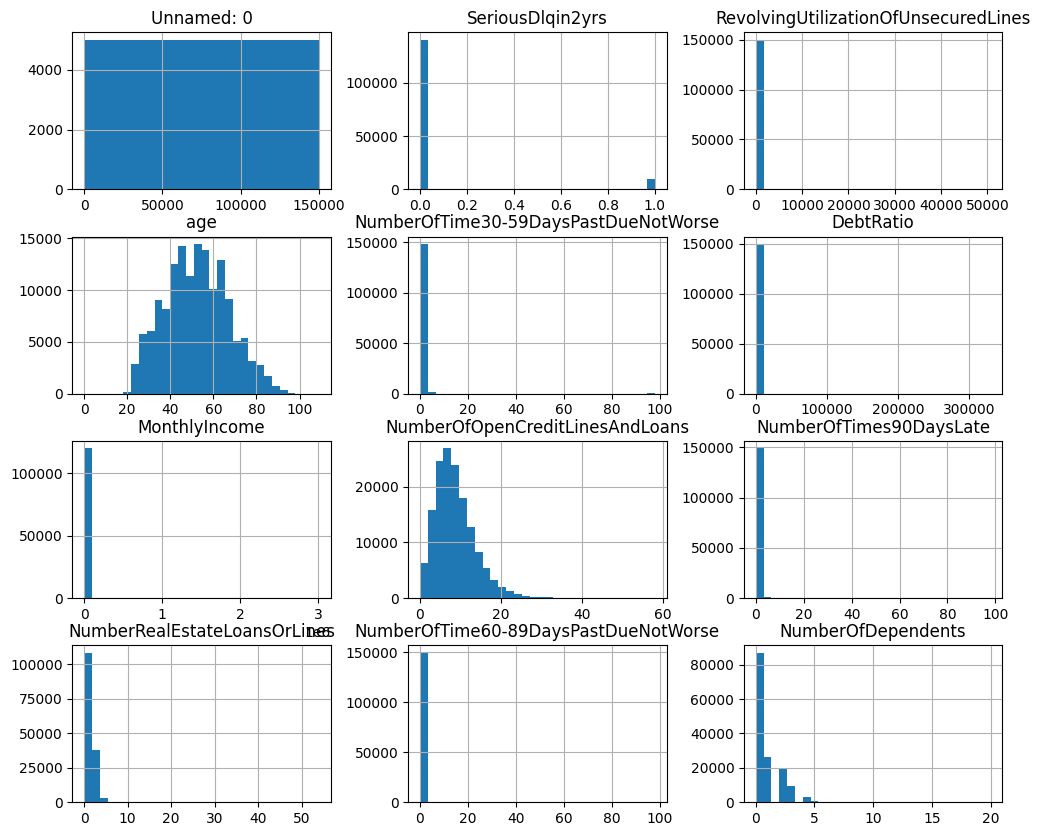

In [3]:
train.hist(figsize=(12, 10), bins=30)
plt.show()

In [4]:
import pandas as pd

# Подсчёт значений целевой переменной SeriousDlqin2yrs
class_counts = train['SeriousDlqin2yrs'].value_counts()

# Вывод результатов
print(f"Количество 1 (клиентов с серьезными просрочками): {class_counts[1]}")
print(f"Количество 0 (клиентов без серьезных просрочек): {class_counts[0]}")

Количество 1 (клиентов с серьезными просрочками): 10026
Количество 0 (клиентов без серьезных просрочек): 139974


Изучив данные, можно заметить явный дисбаланс классов: целевая переменная SeriousDlqin2yrs принимает значение 1 в 10026 случаев, а 0 в 139974 случаев. Это повлияет на выбор метрики оценки (возьмём ROC-AUC, так как она хорошо работает с такими ситуациями), а также на выбор модели машинного обучения (выберем XGBoost, так как эта модель, помимо всего прочего, также устойчива к дисбалансу).

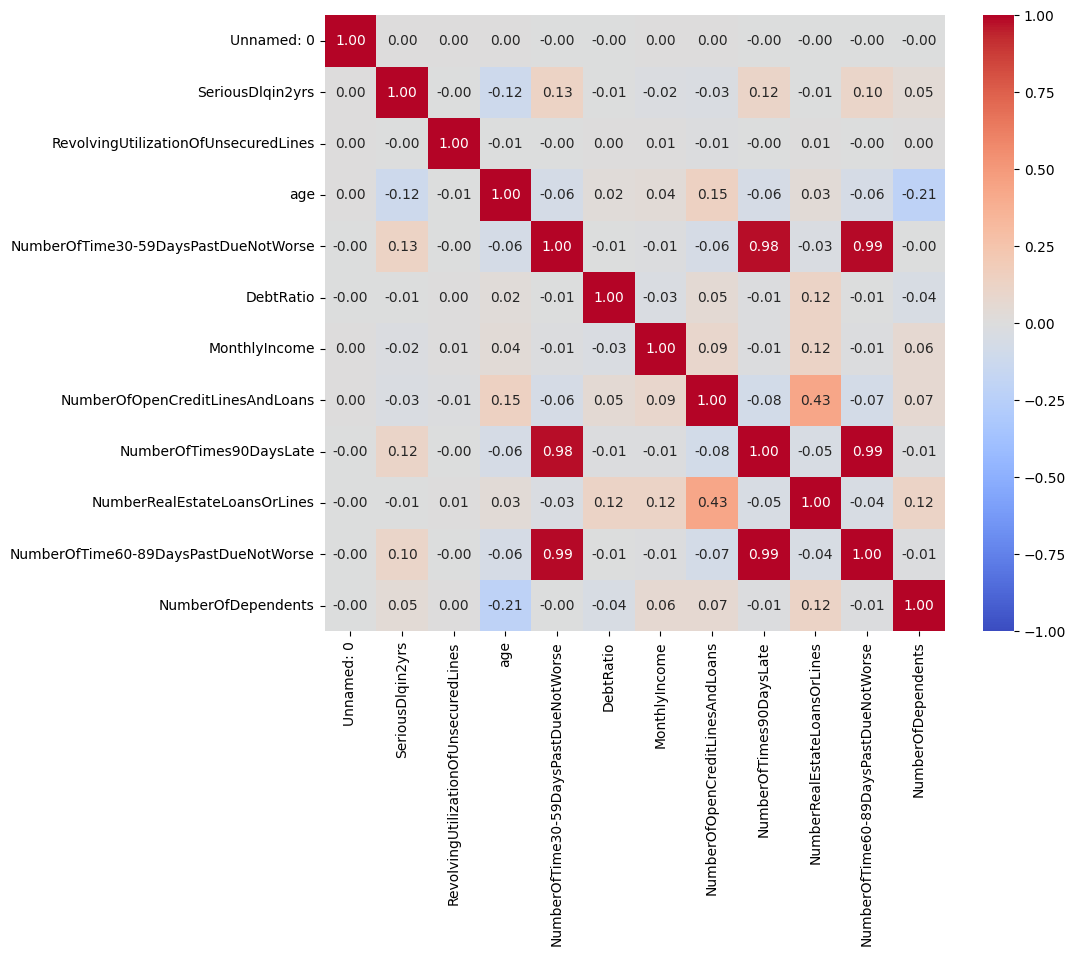

In [5]:
# расчет корреляционной матрицы
corr_matrix = train.corr()

# построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.show()

Можно заметить, что очень сильная корреляция (>= 0.98) наблюдается у признаков NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate и NumberOfTime30-59DaysPastDueNotWorse. Так как мы будем использовать модель машинного обучения XGBoost, которая устойчива к мультиколлинеарности, то мы оставим всё, как есть. Однако если бы мы использовали модели менее устойчивые к мультиколлинеарности (к примеру, логистическая регрессия), то можно было бы:
1. Оставить 1 из этих 3 признаков
2. Объединить 3 этих признака в 1
3. Использовать методы регуляризации

# 2. Обработка данных

## 2.1. Посмотрим количество пропущенных значений для каждого признака

In [6]:
print("Пропущенные значения в cs-training.csv:")
print(train.isnull().sum())
print("\nПропущенные значения в cs-test.csv:")
print(test.isnull().sum())

Пропущенные значения в cs-training.csv:
Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Пропущенные значения в cs-test.csv:
Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoa

## 2.1. Посмотрим количество пропущенных значений для каждого признака в процентах

In [7]:
print("Пропущенные значения в cs-training.csv в %:")
print((train.isnull().sum() / train.shape[0] * 100).round(2).astype(str) + "%")
print("\nПропущенные значения в cs-test.csv в %:")
print((test.isnull().sum() / test.shape[0] * 100).round(2).astype(str) + "%")

Пропущенные значения в cs-training.csv в %:
Unnamed: 0                                0.0%
SeriousDlqin2yrs                          0.0%
RevolvingUtilizationOfUnsecuredLines      0.0%
age                                       0.0%
NumberOfTime30-59DaysPastDueNotWorse      0.0%
DebtRatio                                 0.0%
MonthlyIncome                           19.82%
NumberOfOpenCreditLinesAndLoans           0.0%
NumberOfTimes90DaysLate                   0.0%
NumberRealEstateLoansOrLines              0.0%
NumberOfTime60-89DaysPastDueNotWorse      0.0%
NumberOfDependents                       2.62%
dtype: object

Пропущенные значения в cs-test.csv в %:
Unnamed: 0                                0.0%
SeriousDlqin2yrs                        100.0%
RevolvingUtilizationOfUnsecuredLines      0.0%
age                                       0.0%
NumberOfTime30-59DaysPastDueNotWorse      0.0%
DebtRatio                                 0.0%
MonthlyIncome                           19.81%
NumberOf

Заметим, что пропуски есть только в столбцах MonthlyIncome и NumberOfDependents, причём доля пропущенных значений сравнительно небольшая. Поэтому есть смысл сохранить признаки, а пропущенные значения заменить на медианы.

## 2.2. Заменим пропущенные значения на медианы

In [8]:
# заменяем пропущенные значения для столбца MonthlyIncome
train['MonthlyIncome'] = train['MonthlyIncome'].fillna(train['MonthlyIncome'].median())
test['MonthlyIncome'] = test['MonthlyIncome'].fillna(test['MonthlyIncome'].median())

# заменяем пропущенные значения для столбца NumberOfDependents
train['NumberOfDependents'] = train['NumberOfDependents'].fillna(train['NumberOfDependents'].median())
test['NumberOfDependents'] = test['NumberOfDependents'].fillna(test['NumberOfDependents'].median())

## 2.2. Проверяем, что пропущенных значений больше не осталось

In [9]:
print("Пропущенные значения в cs-training.csv:")
print(train.isnull().sum())
print("\nПропущенные значения в cs-test.csv:")
print(test.isnull().sum())

Пропущенные значения в cs-training.csv:
Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Пропущенные значения в cs-test.csv:
Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate       

## 2.3. Работа с выбросами в данных

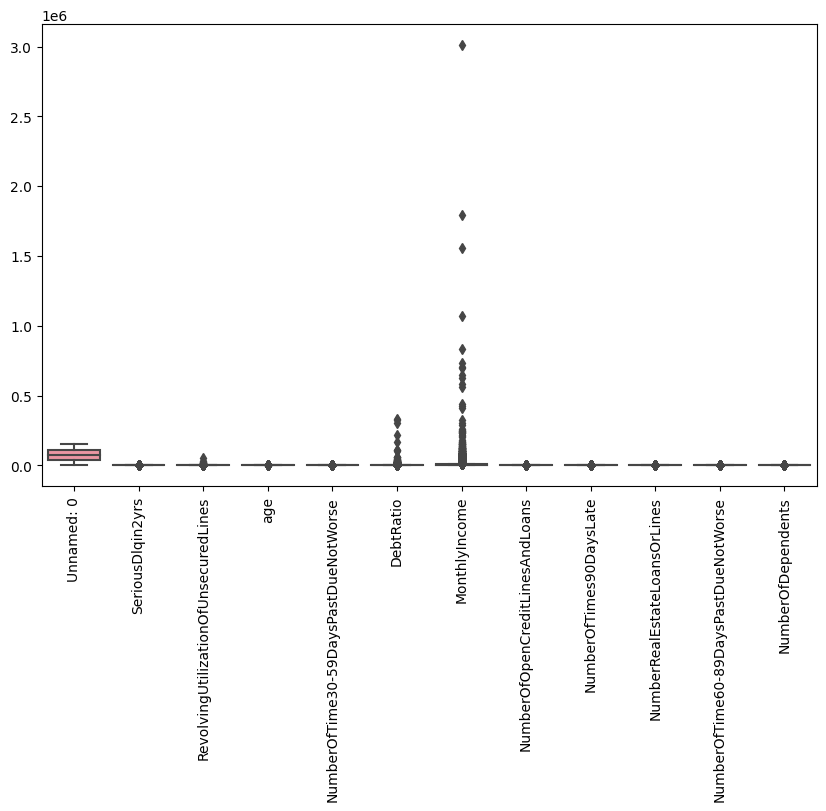

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

С помощью boxplot мы убедились, что в данных есть выбросы. Однако из-за контекста задачи эти данные также являются ценными, ведь помогают модели ознакомиться хоть и с редкими, но возможными сценариями. Поэтому мы их оставим, ведь они представляют ценность с точки зрения полезной информации, которую могут дать.

# 3. Кодировка категориальных признаков

Среди наших признаков нет категориальных, поэтому данный шаг мы пропустим.

# 4. Нормализация числовых данных

Так как мы будем использовать модель машинного обучения XGBoost, которая основана на решающих деревьях, то нормализация данных не требуется.

# 5. Выберем и обучим модель машинного обучения

Для данной задачи возьмём модель машинного обучения XGBoost (Extreme Gradient Boosting), так как она обладает высокой предсказательной мощностью, может обрабатывать несбалансированные данные (к примеру, с большим дисбалансом классов целевой переменной, как у нас), устойчива к мультиколлинеарности и эффективно обрабатывает большие данные.

In [11]:
# Определение признаков и целевой переменной
features = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
            'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
            'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

X = train[features]
y = train['SeriousDlqin2yrs']

# Разделение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)  # Указываем eval_metric для корректной работы XGBoost
model.fit(X_train, y_train)

# Предсказание вероятностей для положительного класса (класс 1)
y_pred_prob = model.predict_proba(X_val)[:, 1]

# Оценка модели с использованием ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.8563


Получили результат ROC-AUC: 0.8563, что является очень хорошим для данного вида задач. Однако можно попробовать сделать модель ещё более эффективной с помощью настройки гиперпараметров. Воспользуемся перебором по сетке: поиск наилучших комбинаций гиперпараметров, использующий заданную сетку возможных значений.

In [12]:
# пока не будем из-за слишком долгой работы
# # Определение параметров для Grid Search
# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.3, 0.7, 1.0],
#     'gamma': [0, 0.1, 0.5],
#     'scale_pos_weight': [1, 3, 5]
# }

# # Инициализация модели XGBoost с использованием GPU
# model = xgb.XGBClassifier(
#     eval_metric='logloss',
#     tree_method='hist',  # Используем метод 'hist' для дерева
#     device='cuda'        # Указываем использование GPU с помощью CUDA
# )

# # Настройка Grid Search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# # Запуск поиска
# grid_search.fit(X_train, y_train)

# # Результаты
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best ROC-AUC score: {grid_search.best_score_:.4f}")


# 6. Воспользуемся моделью для предсказания на тестовом наборе

In [13]:
# Предсказание на тестовом наборе
X_test = test[features]
probabilities = model.predict_proba(X_test)[:, 1]


# Сохранение результатов в файл
submission = pd.DataFrame({'Id': test['Unnamed: 0'], 'Probability': probabilities})
submission.to_csv('submission.csv', index=False)